# ns-emulator-solar
Shows how I add emulation error into the likelihood equation:
- Hare is taken directly from the grid
- No observational noise added to observed values (i.e. true = obs)
- No we treat emulation uncertainty properly by adding in quadrature in the likelihood

I want to test whether the issue of bitty posteriors is from the sampling method or the number of live points (or neither).

In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_v2 import WMSE
from pitchfuncs_v2 import InversePCA
from pitchfuncs_v2 import emulator
from pitchfuncs_v2 import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
import astropy.constants
import pickle
from matplotlib.pyplot import cm
import json


def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())


2024-04-26 14:35:57.711545: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 14:35:57.711575: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 14:35:57.712436: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 14:35:57.717430: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 14:35:58.253590: W tensorflow/compiler/tf2

## 1) import hare and pitchfork

In [2]:
hare = pd.read_json("solar_hare.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i+1}' for i in range(5,40)]
hare_true = hare[outputs]

hare

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,star_feh,nu_0_4,...,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std,log_calc_effective_T_std
3806715,0.98,0.013508,0.24,2.1,4.384008,0.938134,0.796204,5633.170928,-0.046555,736.048182,...,0.891185,0.892424,0.893956,0.895084,0.895033,0.896013,0.896049,0.894976,0.892958,-0.378239


In [3]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

2024-04-26 14:35:59.471253: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-26 14:35:59.471276: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-04-26 14:35:59.471281: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-04-26 14:35:59.471365: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-04-26 14:35:59.471383: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.171.4
2024-04-26 14:35:59.471387: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.171.4


initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


## 2) define priors
this uses the min and max trained ranges stored in the emulator pickle dict

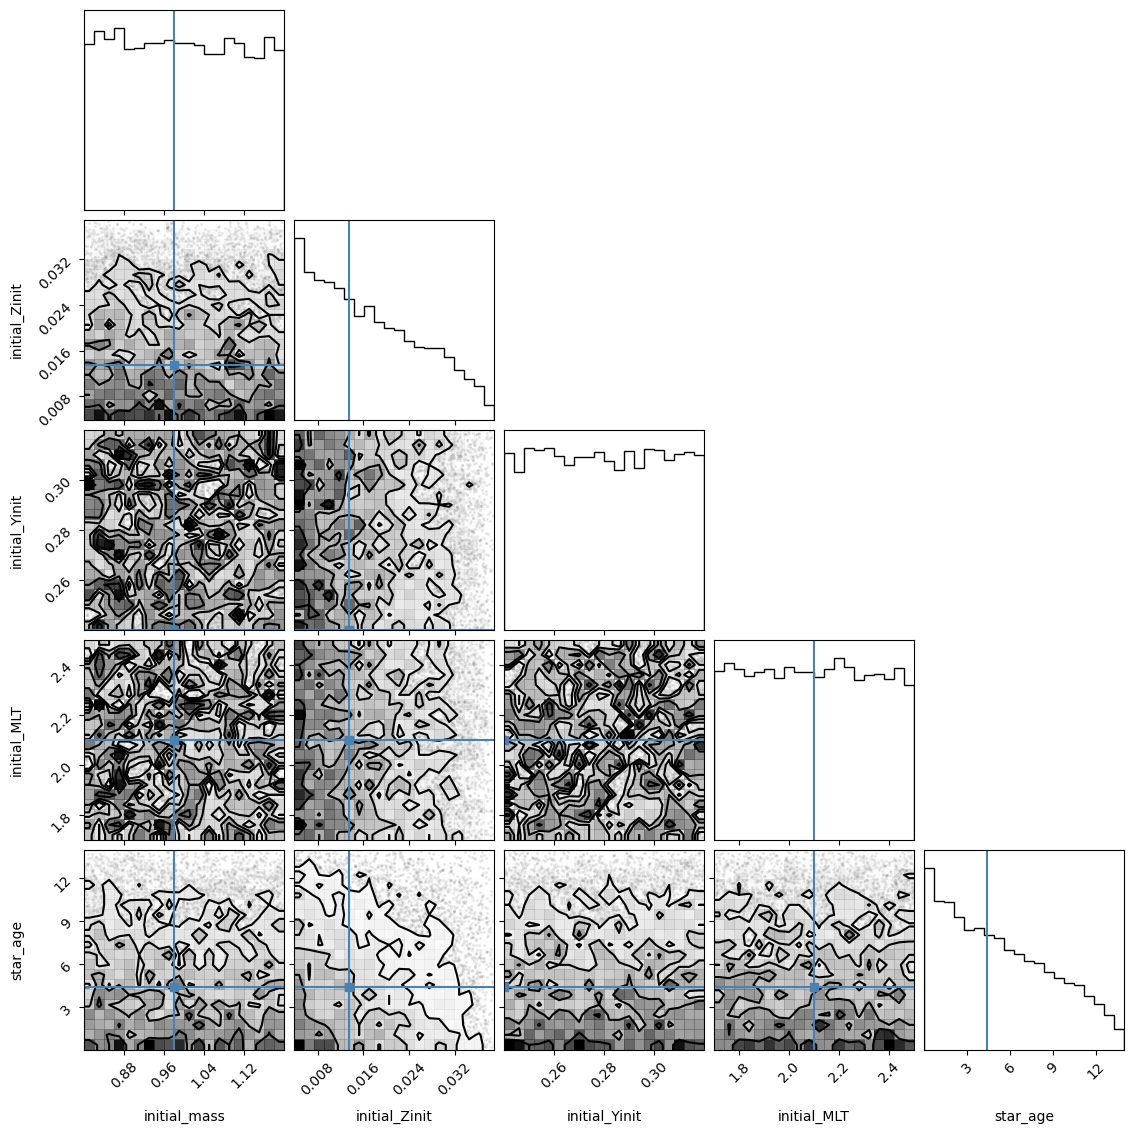

In [4]:
def grid_uniform_prior(pitchfork_ranges, header):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.uniform(loc=grid_min, scale=max(list(pitchfork_ranges["log_"+header].values()))-grid_min)

def grid_beta_prior(pitchfork_ranges, header,a=1,b=1):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.beta(loc=grid_min, scale=grid_max-grid_min, a=a, b=b)

mass_prior = grid_uniform_prior(pitchfork_ranges, "initial_mass")

Zinit_prior = grid_beta_prior(pitchfork_ranges,"initial_Zinit",a=0.9, b=1.5)

Yinit_prior = grid_uniform_prior(pitchfork_ranges, "initial_Yinit")

MLT_prior = grid_uniform_prior(pitchfork_ranges, "initial_MLT")

age_prior = grid_beta_prior(pitchfork_ranges, "star_age", a=0.9, b=1.5)

priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});

## 2) define uncertainties
this time we're taking emulation error seriously, define the observational uncertainty as before:

In [5]:
teff_unc = 70 #K
luminosity_unc = 0.02 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = .5 #\muHz

obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc for i in range(6,41)])
obs_unc

array([7.e+01, 2.e-02, 1.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01])

and now we load in the MAD of the emulator residuals as our emulation error on each parameter:

In [6]:
with open('emulator_unc.json') as json_file:
    emulator_unc_dict = json.load(json_file)

emulator_unc_dict['calc_effective_T'] = emulator_unc_dict.pop('effective_T')

emulator_unc = np.array([emulator_unc_dict[output]['mad'] for output in outputs])
emulator_unc

array([2.12793062e+00, 1.66231780e-03, 4.03602287e-04, 1.85034031e-01,
       2.22244714e-01, 2.27513928e-01, 1.97170428e-01, 2.22129242e-01,
       2.02471613e-01, 2.13496492e-01, 2.10792568e-01, 2.24209510e-01,
       2.17267627e-01, 2.30512340e-01, 2.32739613e-01, 2.42915362e-01,
       2.50060987e-01, 2.50914142e-01, 2.75051143e-01, 2.96329778e-01,
       3.08173680e-01, 3.15907010e-01, 3.36237496e-01, 3.63644449e-01,
       3.54595154e-01, 4.01160577e-01, 3.91218661e-01, 3.96940392e-01,
       4.31924248e-01, 4.20241798e-01, 4.68892806e-01, 4.67736074e-01,
       4.79265714e-01, 5.26056086e-01, 4.78762286e-01, 5.53279110e-01,
       5.26556364e-01, 5.73798990e-01])

now we add these in quadrature to define our uncertainty that we use in the likelihood function:

In [7]:
unc = np.sqrt(obs_unc**2 + emulator_unc**2)
unc

array([7.00323360e+01, 2.00689636e-02, 1.00000814e-01, 5.33139375e-01,
       5.47167902e-01, 5.49329216e-01, 5.37472025e-01, 5.47121010e-01,
       5.39439296e-01, 5.43673387e-01, 5.42617275e-01, 5.47968890e-01,
       5.45165316e-01, 5.50577823e-01, 5.51514032e-01, 5.55884766e-01,
       5.59044271e-01, 5.59426409e-01, 5.70660259e-01, 5.81215397e-01,
       5.87342334e-01, 5.91436589e-01, 6.02540997e-01, 6.18253415e-01,
       6.12974489e-01, 6.41038071e-01, 6.34863797e-01, 6.38405572e-01,
       6.60725780e-01, 6.53148657e-01, 6.85463685e-01, 6.84672940e-01,
       6.92600625e-01, 7.25765117e-01, 6.92252357e-01, 7.45733044e-01,
       7.26127815e-01, 7.61081652e-01])

## 3) define observed values
here's where we'd add simulated observational noise to the "true" values from the hare - in this notebook I assume we happen to observe exactly the truth values, so again this part is easy:

In [8]:
hare_obs = hare_true

## 4) show log-likelihood
now we've defined our "observed" values $\textbf{y}$ and their associated uncertainties $\sigma_{y,\textrm{obs}}$ and $\sigma_{y,\textrm{NN}}$, we have what we need to define our log-likelihood function that we'll use during nested sampling:
$$\mathcal{L}(\textbf{y}|\theta) = \sum_{i}\log\mathcal{N}(y_{i}, \sqrt{\sigma_{y_{i},\textrm{obs}}^2 + \sigma_{y_{i},\textrm{NN}}^2}),$$
Now we're properly incorporating neural network uncertainty into our likelihood equation!

## 5) run dynesty

iter: 6025 | +250 | bound: 140 | nc: 1 | ncall: 137665 | eff(%):  4.566 | loglstar:   -inf < -26.225 <    inf | logz: -48.923 +/-    nan | dlogz:  0.001 >  0.259                                     

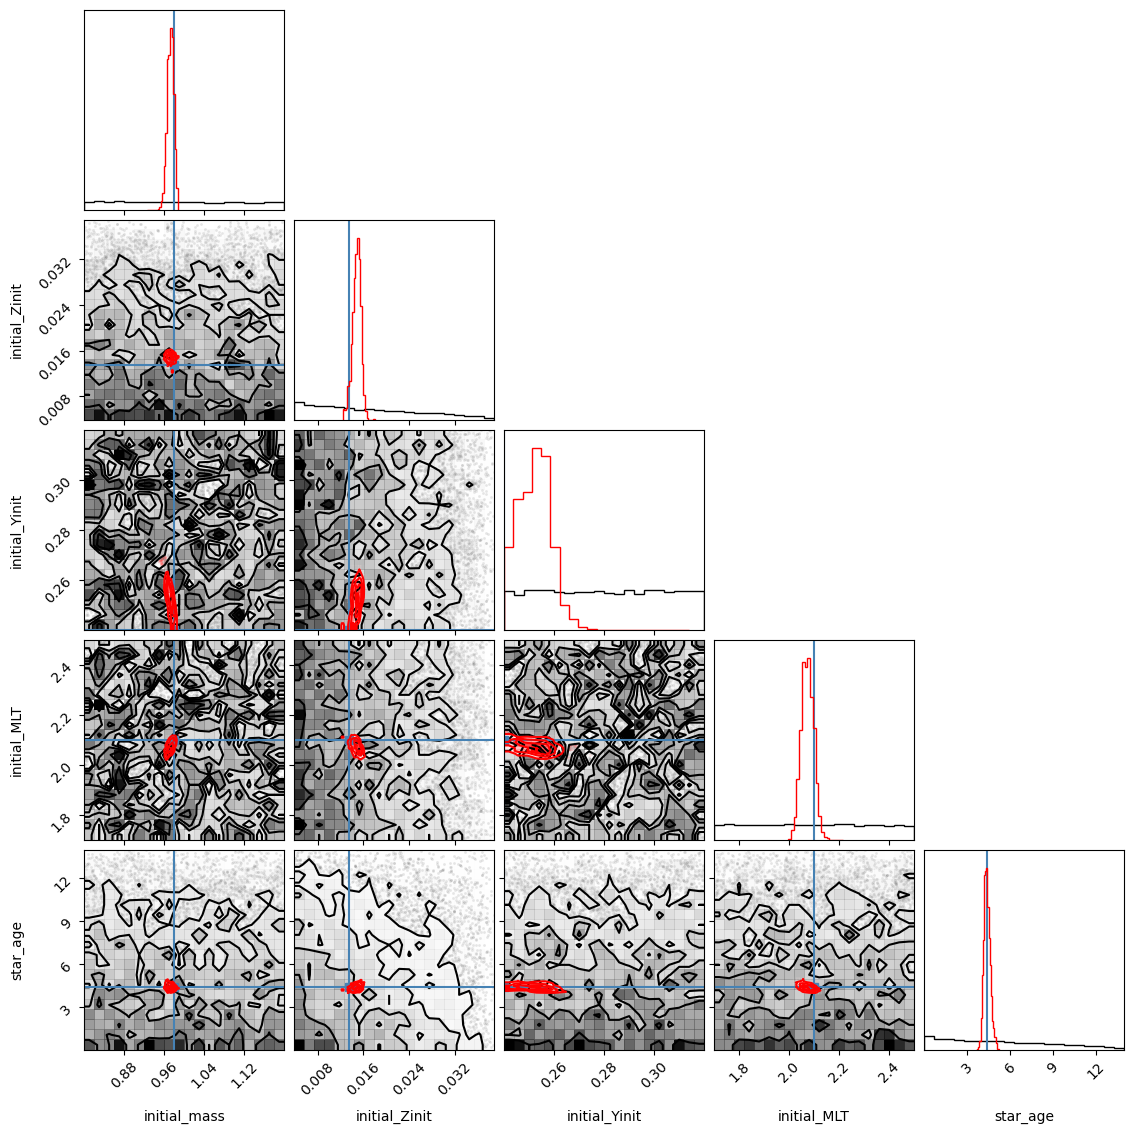

In [9]:
tic = time.time()
sampler = ns(priors=priors, observed_vals=hare_obs, observed_unc=unc, pitchfork=pitchfork, logl_scale=1)
posterior = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
corner.corner(posterior, fig=figure, color='red',hist_kwargs={'density':True});

# 6) nlive test
try sampling for the same Hare at different nlive values to see what we end up with

In [ ]:
nlives = [250, 500, 1000]

posteriors_dict = {}
for nlive in nlives:
    print(f'current nlive: {nlive}', end='\r')
    sampler = ns(priors=priors, observed_vals=hare_obs, observed_unc=unc, pitchfork=pitchfork, logl_scale=1)
    posterior_i = sampler(nlive=nlive,sample='rwalk', bound='multi')
    posteriors_dict[f'posterior_{nlive}'] = posterior_i

iter: 5055 | bound: 112 | nc: 25 | ncall: 112776 | eff(%):  4.482 | loglstar:   -inf < -31.054 <    inf | logz: -51.335 +/-  7.498 | dlogz:  4.455 >  0.259                                           

In [ ]:
nlives = [250, 500, 1000]

color = iter(cm.rainbow(np.linspace(0, 1, len(nlives))))
figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
for nlive in nlives:
    c = next(color)
    corner.corner(posteriors_dict[f'posterior_{nlive}'], fig=figure, color=c,hist_kwargs={'density':True});

color = iter(cm.rainbow(np.linspace(0, 1, len(nlives))))
i=0
for nlive in nlives:
    c = next(color)
    if i == 0:
        figure = corner.corner(posteriors_dict[f'posterior_{nlive}'], labels = inputs, truths = hare_inps.values[0], color=c,hist_kwargs={'density':True});
        i+=1
    else:
        corner.corner(posteriors_dict[f'posterior_{nlive}'], fig=figure, color=c,hist_kwargs={'density':True});

These all look very good! However, I'm using a fairly unrestrictive $\sigma_{obs}$ for $\nu$ of $\sim0.5\mu \textrm{Hz}$. What if we make this more conservative (and realistic)?

## 7) what about with a "spikier" likelihood?
Setting the frequency uncertainty to be lower for intermediate radial orders ($\sim .2 \mu \textrm{Hz}$) and increase for higher and lower n. This is still a little unrealistic as the uncertainty doesn't increase symmetrically about $\nu_{max}$, but it'll do for now:

In [ ]:
teff_unc = 70 #K
luminosity_unc = 0.02 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = .2 #\muHz

unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc + 0.05*(np.abs(i-23))**2 for i in range(6,41)])

nlives = [250, 500, 1000]

posteriors_dict_nu = {}
for nlive in nlives:
    print(f'current nlive: {nlive}', end='\r')
    sampler = ns(priors=priors, observed_vals=hare_obs, observed_unc=unc, pitchfork=pitchfork, logl_scale=1)
    posterior_i = sampler(nlive=nlive,sample='rwalk', bound='multi')
    posteriors_dict_nu[f'posterior_{nlive}'] = posterior_i

In [ ]:
color = iter(cm.rainbow(np.linspace(0, 1, len(nlives))))
figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
for nlive in nlives:
    c = next(color)
    corner.corner(posteriors_dict_nu[f'posterior_{nlive}'], fig=figure, color=c,hist_kwargs={'density':True});

color = iter(cm.rainbow(np.linspace(0, 1, len(nlives))))
i=0
for nlive in nlives:
    c = next(color)
    if i == 0:
        figure = corner.corner(posteriors_dict_nu[f'posterior_{nlive}'], labels = inputs, truths = hare_inps.values[0], color=c,hist_kwargs={'density':True});
        i+=1
    else:
        corner.corner(posteriors_dict_nu[f'posterior_{nlive}'], fig=figure, color=c,hist_kwargs={'density':True});